## LSTM capacity experiments

In [9]:
import lstm_network
import xml_utils
import input_generator
import text_processing
import tensorflow as tf
from pylab import *

from __future__ import division

reload(lstm_network)
reload(xml_utils)
reload(input_generator)

<module 'input_generator' from 'input_generator.pyc'>

In [2]:
graph =  tf.Graph()

hparams = {}
hparams['bp_cutoff'] = 5
hparams['batch_size'] = 10
hparams['n_inputs'] = 26
hparams['n_units'] = 100
hparams['forget_bias'] = 1.0
hparams['grad_clip_norm'] = 1
hparams['n_train_steps'] = int(1e4)
hparams['train_state_reset_rate'] = 100


#bp_cutoff = 5

with graph.as_default():
    xs = [tf.placeholder(tf.float32, shape=[hparams['batch_size'], hparams['n_inputs']]) for _ in arange(hparams['bp_cutoff']+1)]
    
    # predicting next letter, output is next input
    x_inputs = xs[:-1]
    x_labels = xs[1:]
    
    # set up network/graph
    lstm_net = lstm_network.LSTMnet(hparams)
    
    errors = list()
    
    init_state = lstm_net.get_new_state(hparams['batch_size'])
    
    train_state = init_state
    
    for (x_input, x_label) in zip(x_inputs, x_labels):
        train_state, y = lstm_net.step(train_state, x_input)
        
        # @todo: check to see if this step is actually predictable
        cross_entropy = tf.nn.softmax_cross_entropy_with_logits(y, x_label)
        
        errors.append(cross_entropy)
        
        
    train_err = tf.reduce_mean(tf.concat(0, errors))
        
    
    store_train_state = lstm_net.store_state_op(train_state, init_state)
    reset_state = lstm_net.reset_state_op(init_state)
    
    # set up training optimizer
    t = tf.Variable(0, name='t', trainable=False)
    
    eta = tf.train.exponential_decay(0.008, t, 2000, 0.5, staircase=True)
    optimizer = tf.train.AdamOptimizer(learning_rate=eta)
    
    
    grads, params = zip(*optimizer.compute_gradients(train_err))
    grads, _ = tf.clip_by_global_norm(grads, hparams['grad_clip_norm'])
    apply_grads = optimizer.apply_gradients(zip(grads, params), global_step=t)
    
    

In [3]:
num_chars_per_tag = 10
tag_depth = 4
num_tags = 100

text, xml_alphabet = xml_utils.generate_xml_sequence(num_chars_per_tag, tag_depth, num_tags)

#xml_alphabet, indices = text_processing.string_to_alphabet_indices(text)

input_gen = input_generator.Input_Generator(text, xml_alphabet, hparams['batch_size'], hparams['bp_cutoff'])

In [4]:
text

array([20, 13, 11, ..., 17, 16,  3])

In [ ]:
cum_error = 0

with tf.Session(graph=graph) as session:

    tf.initialize_all_variables().run()
    
    for step in range(hparams['n_train_steps']):
        
        reset_rate = hparams['bp_cutoff']/hparams['train_state_reset_rate']
        if np.random.poisson(reset_rate) > 0:
            print 'reset'
            session.run([reset_state])
        
        
        window = input_gen.next_window()
        
        feed_dict = dict()
        
        for i in range(hparams['bp_cutoff']+1):
            feed_dict[xs[i]] = window[i]
            
        to_compute = [train_err, eta, apply_grads, store_train_state]
        
        error_val, eta_val = session.run(to_compute, feed_dict=feed_dict)[:2]
        
        cum_error += error_val
        
        print cum_error
        
        
        
        

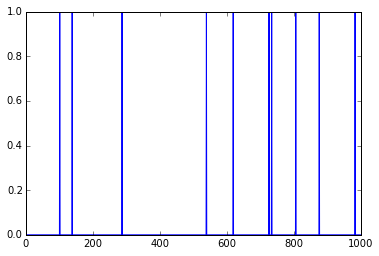

In [31]:
%matplotlib inline
plot(np.random.poisson(1.0/100, [1000]))

In [44]:
a.size

2

In [17]:
alphabet = 'abcdefghijklmnopqrstuvwxyz'
aa = []
for l in alphabet:
    aa.append(l)
aa = np.array(aa)
idx = np.random.randint(len(alphabet), size=100)
print aa[idx]

['e' 'd' 'v' 'h' 'r' 'b' 'x' 'b' 'v' 'g' 'c' 'q' 't' 'n' 'g' 'i' 'q' 'g'
 'v' 'n' 'k' 'l' 't' 'w' 'l' 'd' 'u' 'z' 'o' 'f' 'r' 's' 'y' 'v' 'k' 'c'
 'u' 'v' 'h' 'g' 'i' 'g' 'd' 'k' 'u' 'i' 'r' 'i' 'p' 'v' 'i' 'i' 'k' 'z'
 'e' 'h' 'z' 'f' 'b' 'a' 'f' 'f' 'w' 'j' 's' 'g' 'm' 's' 'p' 'u' 'z' 'a'
 'n' 'v' 'x' 'i' 'f' 'm' 'v' 'q' 's' 'r' 'w' 'r' 'c' 'c' 'e' 'l' 'i' 'a'
 'e' 'e' 's' 'j' 'v' 'i' 't' 'o' 'b' 'o']


In [21]:
aa2 = np.array(list(alphabet))
print aa2
print str(list(aa2))

['a' 'b' 'c' 'd' 'e' 'f' 'g' 'h' 'i' 'j' 'k' 'l' 'm' 'n' 'o' 'p' 'q' 'r'
 's' 't' 'u' 'v' 'w' 'x' 'y' 'z']
['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [28]:
reload(xml_utils)
xml_seq = xml_utils.generate_rand_xml_sequence([8, 9, 10], [3, 4, 5], 40)

[True, True, True, True, True, False, False, False, False, False, True, True, True, True, False, False, False, False, True, True, True, True, False, False, False, False, True, True, True, True, True, False, False, False, False, False, True, True, True, True, False, False, False, False, True, True, True, True, True, False, False, False, False, False, True, True, True, True, True, False, False, False, False, False, True, True, True, False, False, False, True, True, True, True, True, False, False, False, False, False, True, True, True, True, False, False, False, False, True, True, True, True, False, False, False, False, True, True, True, False, False, False, True, True, True, True, True, False, False, False, False, False, True, True, True, True, True, False, False, False, False, False, True, True, True, False, False, False, True, True, True, True, False, False, False, False, True, True, True, False, False, False, True, True, True, True, False, False, False, False, True, True, True, True, 

In [27]:
print "".join(xml_seq)

<topzwrtwqw><oqfnxjipnz><owsotxumda><oslctbakpl>-oslctbakpl>-owsotxumda>-oqfnxjipnz>-topzwrtwqw><xzmkbqxpiu><thenivuoog><ioqobopgjo><gpojbkuggc>-gpojbkuggc>-ioqobopgjo>-thenivuoog>-xzmkbqxpiu><vaczvssewy><bbrghkixey><xqwuoacyxu><pcskoejwah>-pcskoejwah>-xqwuoacyxu>-bbrghkixey>-vaczvssewy><njdneumour><famqnwyrjy><rjmalywhow><pnwgmfyfnx>-pnwgmfyfnx>-rjmalywhow>-famqnwyrjy>-njdneumour><yycpffwuyx><oreenualoq><tyozerkgam><lhjfiecumy>-lhjfiecumy>-tyozerkgam>-oreenualoq>-yycpffwuyx><fpxhdbhprz><ysyleejiyp><kbzvinddwl><dzqwgmvxya>-dzqwgmvxya>-kbzvinddwl>-ysyleejiyp>-fpxhdbhprz><ufsfyjiyus><wpnsjsmetf><xibailvowm><mppunhxwdl>-mppunhxwdl>-xibailvowm>-wpnsjsmetf>-ufsfyjiyus><fhfiqxkkag><atmcjenewp><dfzqurgoxn><mpiofksqxr>-mpiofksqxr>-dfzqurgoxn>-atmcjenewp>-fhfiqxkkag><hkqpsvcbgo><bzyfmyxxvc><xsloudxjbg><glfsipjrgy>-glfsipjrgy>-xsloudxjbg>-bzyfmyxxvc>-hkqpsvcbgo><lkgqqahqug><hadiiodvyj><lswegrnadu><eafdnxzdfy>-eafdnxzdfy>-lswegrnadu>-hadiiodvyj>-lkgqqahqug><mrwmbiifdb><queojlyzca><asznllixop><htl